# Repurposed classifiers

Most classification algorithms have a regression counterpart. For two of the classification methods we looked at, these are easy to describe and understand.

## Nearest neighbors

To use kNN for regression, we can find the $k$ nearest examples as with classification, but replace voting on classes with averaging of values. As with the classification variant, we can choose the norm to use, and whether to weight the neighbors equally or by inverse distance. Also, it is again recommended to start with z-scores for the features rather than raw data; it is not necessary to standardize the target values being regressed.

As you can see in the following video, increasing $k$ flattens out the surface, decreasing variance while increasing bias.

```{raw} html
<video width=640 controls src="../_static/knn_regression.mp4"></video>
```

## Decision tree

Recall that a decision tree recursively divides the examples into subsets. Instead of using a measure of class impurity to determine the best split, the split is chosen to cause the greatest reduction in dispersion within the two subsets. The most obvious candidates for measuring dispersion are standard deviation and the mean absolute deviation (MAD). If $t_1,\ldots,t_m$ are elements of any set, then their MAD is given by

$$
\text{MAD} = \frac{1}{m} \sum_{i=1}^m | t_i - t_\text{med} |,
$$

where $t_\text{med}$ is the median value. As with classification, a proposal to split into subsets $S$ and $T$ is assigned the weighted score

$$
Q = |S| H(S) + |T| H(T),
$$

where $H$ is the chosen dispersion measure.

::::{prf:example}
:label: example-other-dtree
Choose the best split using the MAD criterion for the observations $x_i=i$, $i=1,\ldots,4$, where $y_1=2$, $y_2=-1$, $y_3=1$, $y_4=0$.

:::{dropdown} Solution
The original set has median $\frac{1}{2}$ and gets a weighted dispersion of $\frac{5}{2}(3+3+1+1)=20$. There are three ways to split the data, depending on where the partition falls in relation to the $x_i$.

* $S=\{2\},T=\{-1,1,0\}$: 

$$ Q &= 1\left[ \frac{1}{1}\left( |2-2| \right)  \right] +  3 \left[ \frac{1}{3}\left( | -1-0 | + |1-0| + |0-0|  \right)  \right]\\ &=  0 + 2 = 2.$$

* $S=\{2,-1\},T=\{1,0\}$: 

$$ Q &= 2\left[ \frac{1}{2}\left( \left| 2-\tfrac{1}{2} \right| + \left| -1-\tfrac{1}{2} \right| \right)  \right] +  2 \left[ \frac{1}{2}\left( \left|1-\tfrac{1}{2} \right| + \left|0-\tfrac{1}{2} \right|  \right)  \right]\\ 
&=  3 + 1 = 4.$$

* $S=\{2,-1,1\},T=\{0\}$: 

$$ Q &= 3\left[ \frac{1}{3}\left( \left| 2-1 \right| + \left| -1-1 \right|+ |1-1| \right)  \right] +  1 \left[ \frac{1}{1}\left(  \left|0-0 \right|  \right)  \right]\\ 
&=  3 + 0 = 3.$$

Thus, the first split above produces the smallest total dispersion.
:::
::::

To predict a value for a query $x$, we follow the tree until ending at a leaf, where we use the mean (if dispersion is STD) or median (if dispersion is MAD) of the examples in the leaf.

Here is a simple example based on two dimensions.

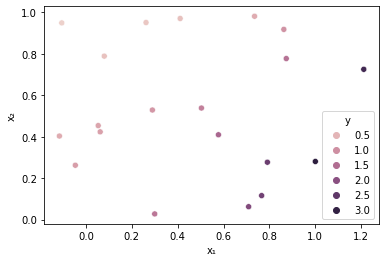

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng(1)
x1 = rng.random((10,2))
x1[:,0] -= 0.25
x2 = rng.random((10,2))
x2[:,0] += 0.25
X = np.vstack((x1,x2))
y = np.exp(X[:,0]-2*X[:,1]**2+X[:,0]*X[:,1])

import seaborn as sns
df = pd.DataFrame({"x₁":X[:,0],"x₂":X[:,1],"y":y})
sns.scatterplot(data=df,x="x₁",y="x₂",hue="y");

Here is a shallow tree for regression on this data. The default choice is to use STD as the dispersion measure (called `squared_error` in sklearn).

[Text(1116.0, 1107.3333333333333, 'x₁ <= 0.541\nsquared_error = 0.73\nsamples = 20\nvalue = 1.237'),
 Text(558.0, 664.4, 'x₂ <= 0.663\nsquared_error = 0.138\nsamples = 11\nvalue = 0.678'),
 Text(279.0, 221.4666666666667, 'squared_error = 0.064\nsamples = 7\nvalue = 0.911'),
 Text(837.0, 221.4666666666667, 'squared_error = 0.007\nsamples = 4\nvalue = 0.271'),
 Text(1674.0, 664.4, 'x₂ <= 0.751\nsquared_error = 0.605\nsamples = 9\nvalue = 1.92'),
 Text(1395.0, 221.4666666666667, 'squared_error = 0.225\nsamples = 6\nvalue = 2.378'),
 Text(1953.0, 221.4666666666667, 'squared_error = 0.103\nsamples = 3\nvalue = 1.004')]

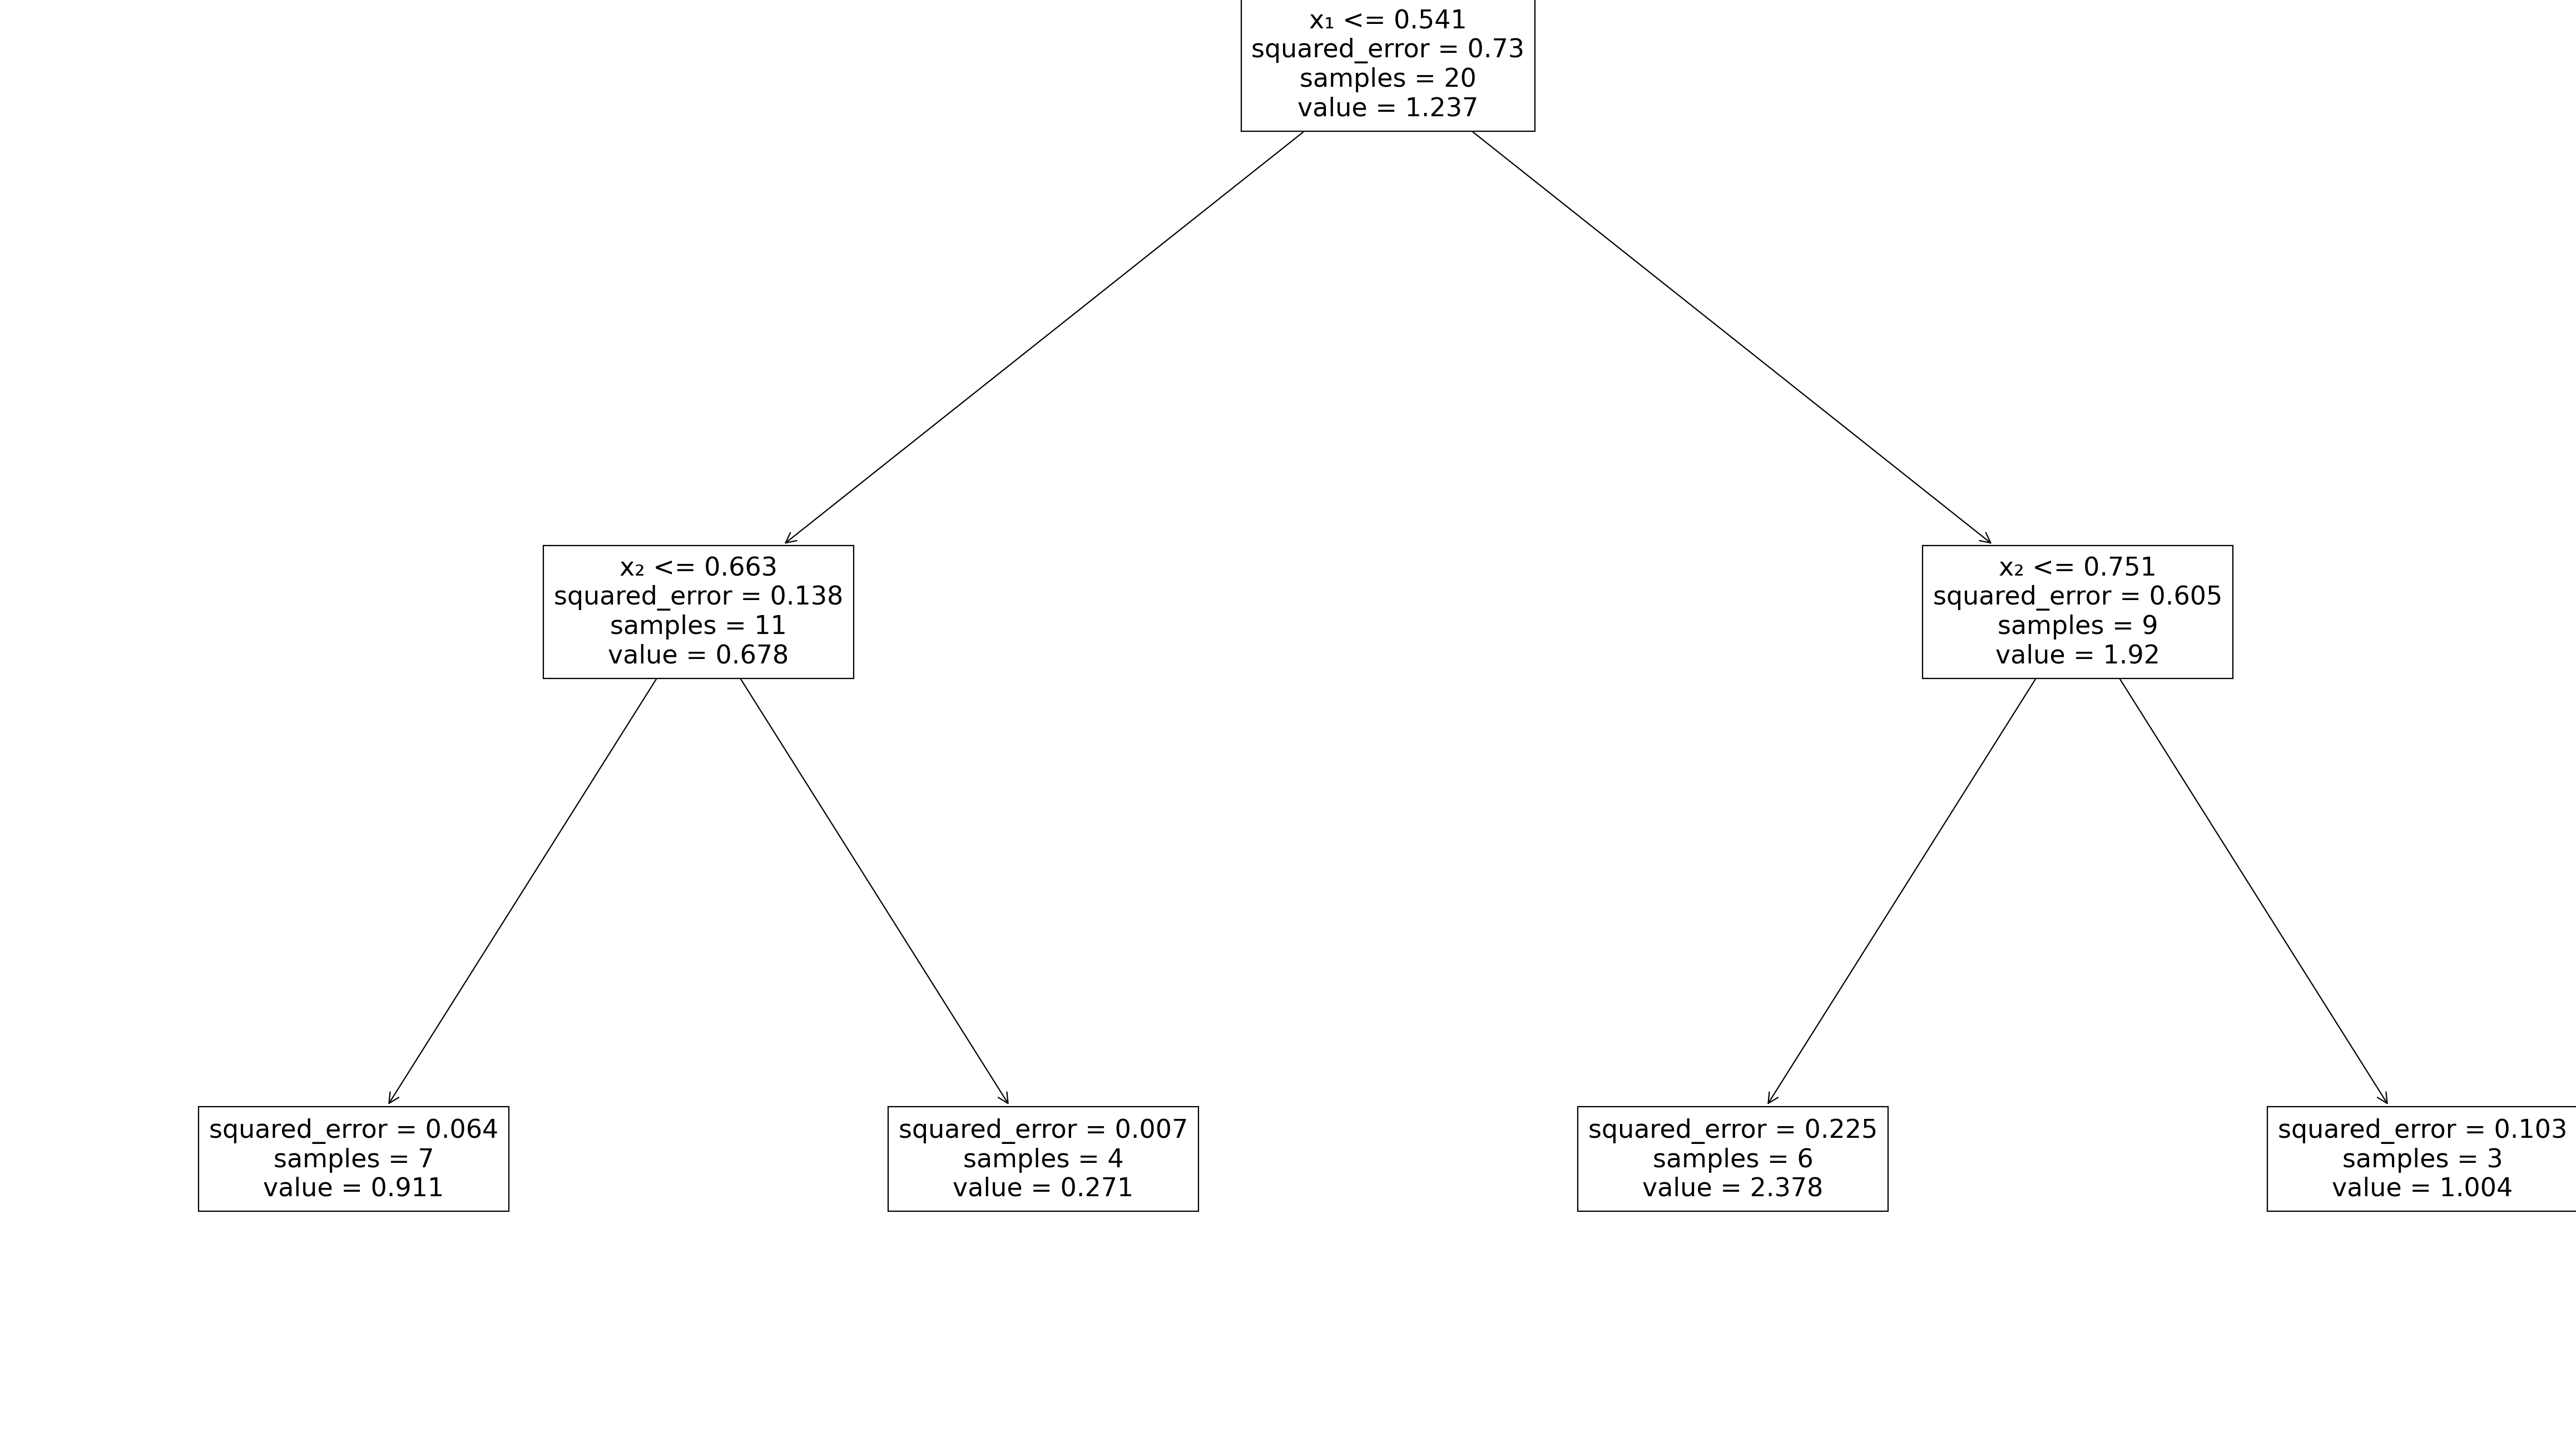

In [2]:
from sklearn.tree import DecisionTreeRegressor,plot_tree
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X,y)

from matplotlib.pyplot import figure
figure(figsize=(18,11),dpi=160)
plot_tree(dt,feature_names=["x₁","x₂"])

All of the original samples end up in one of the four leaves. We can find out which goes where using `apply`:

In [3]:
leaf = dt.apply(X)
print(leaf)

[3 3 2 5 2 2 3 2 2 2 5 6 5 5 3 5 6 6 2 5]


With some pandas splitting, we can find out the mean value for the samples within each leaf:

In [4]:
leaves = pd.DataFrame(zip(y,leaf),columns=["y","leaf"])
leaves.groupby("leaf")["y"].mean()

leaf
2    0.911328
3    0.270725
5    2.378427
6    1.003786
Name: y, dtype: float64

All values of the regressor will be one of the four values above:

In [5]:
print(dt.predict(X))

[0.27072468 0.27072468 0.91132782 2.37842709 0.91132782 0.91132782
 0.27072468 0.91132782 0.91132782 0.91132782 2.37842709 1.00378567
 2.37842709 2.37842709 0.27072468 2.37842709 1.00378567 1.00378567
 0.91132782 2.37842709]
